# Equity Trading Model with DSWS

#### Thesis: 
- The objective of this research project is to predict if the price of an asset (i.e.: SPY ETF) will be higher or lower in N-days from now using price-based (Technical) indicators as features. 

#### Label:
- y = close price in N day > today, 1, else 0

#### Features:
Volatility:
- Average True Range
- Bollinger Bands with 1 STD

Trend Following:
- Moving Average Convergence Divergence Spread
- N-day Simple Moving Average
- Average Directional Index 

Trend Reversal:
- Relative Strength Index
- Stochastic Spread

### Import Packages

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.style.use('seaborn-dark-palette')

import warnings 
warnings.filterwarnings('ignore')

### Import & Clean Data

API Data Pull

In [2]:
import PyDSWS as PyDSWS
ds = PyDSWS.Datastream(username='x', password='x')
df = ds.get_data(tickers='@QQQ, @QQQ(PH), @QQQ(PL), @QQQ(PO)',start="-20Y",end="0", freq="D")
df.columns = ['priceclose','pricehigh','pricelow','priceopen']

In [3]:
df

,priceclose,pricehigh,pricelow,priceopen
Date,,,,
2000-10-12,81.2500,81.6250,74.6250,74.6875
2000-10-15,81.6250,82.3125,79.7500,81.1250
2000-10-16,78.2500,83.1719,78.0000,83.1250
2000-10-17,78.0000,81.1875,74.5625,76.7500
2000-10-18,85.0625,85.1094,81.4375,82.3906
...,...,...,...,...
2020-10-07,281.4099,282.4700,280.3101,282.3201
2020-10-08,285.7100,285.7900,282.7100,283.0901
2020-10-11,294.5300,297.4600,289.4700,290.6001


In [4]:
len(df)

5219

In [5]:
df = df.dropna()

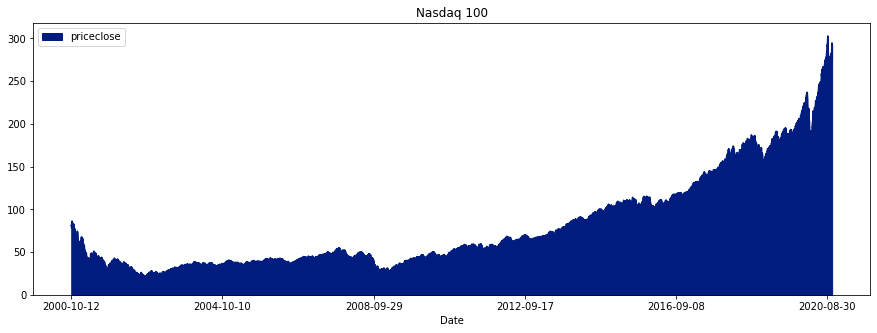

In [6]:
df['priceclose'].plot(figsize=(15,5),kind='area',title='Nasdaq 100',legend=True);

## Features

In [7]:
# Set Y Label
y = -22

df['priceiny'] = np.where(df['priceclose']<df['priceclose'].shift(y),1,0)

#### Price Return

In [8]:
df['pcshift'] = df['priceclose'].shift(1)
df['dailyreturn'] = (((df['priceclose']-df['pcshift'])/df['pcshift'])*100).round(2)

#### Average True Range

In [9]:
df['hmpc'] = abs(df['pricehigh']-df['pcshift'])
df['lmpc'] = abs(df['pricelow']-df['pcshift'])
df['hml'] = df['pricehigh']-df['pricelow']
df['true range'] = df[['hml','hmpc','lmpc']].max(axis=1)
df['atr'] = ((df['true range'].rolling(14).mean().shift(1)*(14-1))+df['true range'])/14

#### Bollinger Bands

In [10]:
rolling_mean = df['priceclose'].rolling(window=14).mean()
rolling_std = df['priceclose'].rolling(window=14).std()

df['bbplus'] = rolling_mean + (rolling_std * 1)
df['bbminus'] = rolling_mean - (rolling_std * 1) 

#### MACD Spread

In [11]:
df['ma12'] = df['priceclose'].rolling(window=12).mean()
df['ma26'] = df['priceclose'].rolling(window=26).mean()

df['ma12shift'] = df['ma12'].shift(1)
df['ma26shift'] = df['ma26'].shift(1)

df['fastma12'] = (df['priceclose']-df['ma12shift'])*(2/(12+1))+df['ma12shift']
df['slowma26'] = (df['priceclose']-df['ma26shift'])*(2/(26+1))+df['ma26shift']

df['madiff'] = df['fastma12']-df['slowma26']
df['madiffshift'] = df['madiff'].shift(1)

df['signalma9'] = (df['madiff']-df['madiffshift'])*(2/(9+1))+df['madiffshift']
df['macdspread'] = df['madiff']-df['signalma9']

#### N-day SMA

In [12]:
df['smaNday'] = df['priceclose'].rolling(window=abs(y)).mean()
df['smaNdummy'] = [1 if row['priceclose']>row['smaNday'] else 0 for idx,row in df.iterrows()]

#### Average Directional Index

In [13]:
df['hmph'] = df['pricehigh']-df['pricehigh'].shift(1)
df['plml'] = df['pcshift']-df['pricelow']

df['+dx'] = [row['hmph'] if row['hmph']>row['plml'] and row['hmph']>0 else 0 for idx,row in df.iterrows()]
df['-dx'] = [row['plml'] if row['plml']>row['hmph'] and row['plml']>0 else 0 for idx,row in df.iterrows()]

df['smooth+dx'] = ((df['+dx'].rolling(window=14).mean().shift(1)*(14-1))+df['+dx'])/14
df['smooth-dx'] = ((df['-dx'].rolling(window=14).mean().shift(1)*(14-1))+df['-dx'])/14

df['+dmi'] = (df['smooth+dx']/df['atr'])*100
df['-dmi'] = (df['smooth-dx']/df['atr'])*100

df['dx'] = ((abs(df['+dmi']-df['-dmi']))/(df['+dmi']+df['-dmi']))*100
df['adx'] = (df['dx'].rolling(window=14).mean().shift(1)*(14-1)+df['dx'])/14

#### Relative Strength Index

In [14]:
df['upmove'] = [row['priceclose']-row['pcshift'] if row['priceclose']>row['pcshift'] else 0 for idx,row in df.iterrows()]
df['dnmove'] = [row['pcshift']-row['priceclose'] if row['priceclose']<row['pcshift'] else 0 for idx,row in df.iterrows()]

df['avgupmove'] = df['upmove'].rolling(window=14).mean()
df['avgdnmove'] = df['dnmove'].rolling(window=14).mean()

df['avgupmoveshift'] = df['avgupmove'].shift(1)
df['avgdnmoveshift'] = df['avgdnmove'].shift(1)

df['avgupmove1'] = (df['avgupmoveshift']*(14-1)+df['upmove'])/14
df['avgdnmove1'] = (df['avgdnmoveshift']*(14-1)+df['dnmove'])/14

df['relstrength'] = df['avgupmove1']/df['avgdnmove1']
df['rsi'] = 100-(100/(df['relstrength']+1))

#### Stochastic Spread

In [15]:
df['stochlow'] = df['priceclose']-(df['pricelow'].rolling(window=14).min())
df['stochhml'] = (df['pricehigh'].rolling(window=14).max())-(df['pricelow'].rolling(window=14).min())
df['%k'] = (df['stochlow']/df['stochhml'])*100
df['%d'] = (df['stochlow'].rolling(window=3).sum()/df['stochhml'].rolling(window=3).sum())*100
df['signal'] = df['%d'].rolling(window=3).mean()

df['stochspread'] = df['%k']-df['signal']

## Feature Exploration

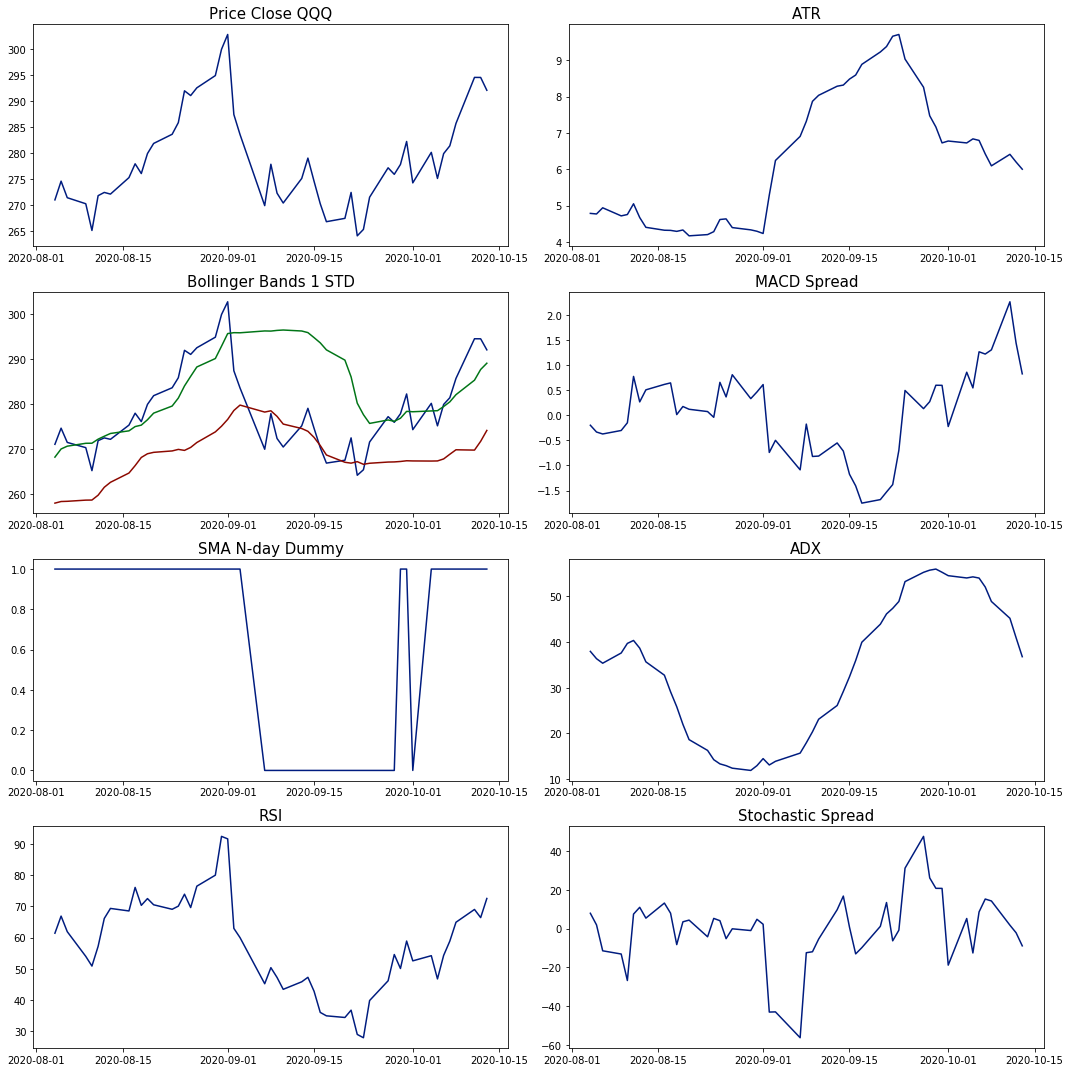

In [16]:
df.index = pd.to_datetime(df.index)

fig = plt.figure(figsize=(15,15))

fig.autofmt_xdate()

ax1 = fig.add_subplot(4,2,1)
ax2 = fig.add_subplot(4,2,2)
ax3 = fig.add_subplot(4,2,3)
ax4 = fig.add_subplot(4,2,4)
ax5 = fig.add_subplot(4,2,5)
ax6 = fig.add_subplot(4,2,6)
ax7 = fig.add_subplot(4,2,7)
ax8 = fig.add_subplot(4,2,8)

ax1.plot(df.index[-50:],df['priceclose'][-50:])
ax1.set_title('Price Close QQQ',size='15')

ax2.plot(df.index[-50:],df['atr'][-50:])
ax2.set_title('ATR',size='15')

ax3.plot(df.index[-50:],df[['priceclose','bbplus','bbminus']][-50:])
ax3.set_title('Bollinger Bands 1 STD',size='15')

ax4.plot(df.index[-50:],df['macdspread'][-50:])
ax4.set_title('MACD Spread',size='15')

ax5.plot(df.index[-50:],df['smaNdummy'][-50:])
ax5.set_title('SMA N-day Dummy',size='15')

ax6.plot(df.index[-50:],df['adx'][-50:])
ax6.set_title('ADX',size='15')

ax7.plot(df.index[-50:],df['rsi'][-50:])
ax7.set_title('RSI',size='15')

ax8.plot(df.index[-50:],df['stochspread'][-50:])
ax8.set_title('Stochastic Spread',size='15')

fig.tight_layout();

In [17]:
df = df[['priceclose','priceiny','dailyreturn','atr', 'bbplus', 'bbminus','smaNdummy','adx','macdspread','rsi','stochspread']]

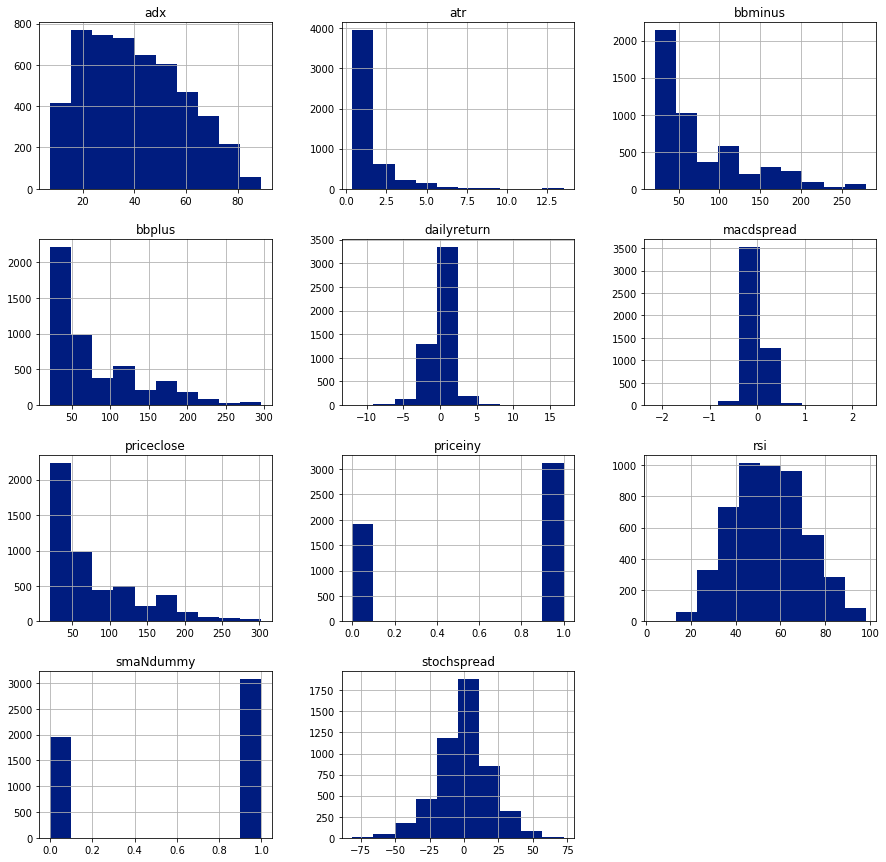

In [18]:
pd.DataFrame.hist(df, figsize = [15,15]);

In [19]:
df.describe().round(2)

,priceclose,priceiny,dailyreturn,atr,bbplus,bbminus,smaNdummy,adx,macdspread,rsi,stochspread
count,5032.00,5032.00,5031.00,5018.00,5019.00,5019.00,5032.00,5004.00,5005.00,5018.00,5015.00
mean,80.13,0.62,0.04,1.42,81.29,78.43,0.61,40.25,0.00,54.90,-0.03
std,56.64,0.49,1.65,1.35,57.19,55.23,0.49,18.83,0.21,16.11,19.10
min,20.06,0.00,-11.98,0.39,21.58,20.24,0.00,7.31,-2.16,3.73,-81.06
25%,39.21,0.00,-0.62,0.69,39.87,38.59,0.00,24.53,-0.07,42.75,-10.69
50%,54.53,1.00,0.10,0.99,55.81,53.45,1.00,38.18,-0.00,54.49,0.55
75%,107.96,1.00,0.76,1.55,109.68,106.18,1.00,54.29,0.07,66.59,11.07
max,302.76,1.00,16.84,13.52,296.48,279.78,1.00,89.20,2.29,98.19,72.35


In [20]:
df[df['dailyreturn'] == df['dailyreturn'].min()].round(2)

,priceclose,priceiny,dailyreturn,atr,bbplus,bbminus,smaNdummy,adx,macdspread,rsi,stochspread
Date,,,,,,,,,,,
2020-03-15,169.3,1,-11.98,12.03,216.31,187.04,0,68.81,-1.81,31.58,-11.85


In [21]:
df[df['dailyreturn'] == df['dailyreturn'].max()].round(2)

,priceclose,priceiny,dailyreturn,atr,bbplus,bbminus,smaNdummy,adx,macdspread,rsi,stochspread
Date,,,,,,,,,,,
2001-01-02,62.44,0,16.84,4.9,64.92,56.73,0,45.62,0.09,36.78,23.41


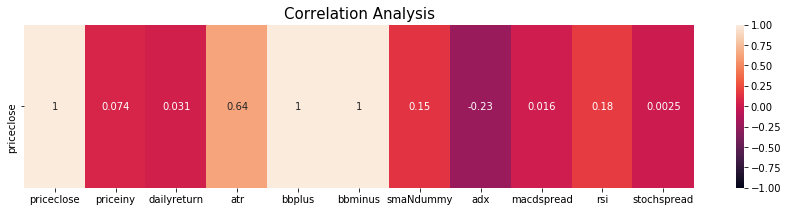

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(15,3))
sns.heatmap(df.corr()[0:1],vmin=-1,vmax=1,annot=True)
ax.set_title('Correlation Analysis', size=15);

Correlation Analysis:
- The non-stationary time-series features are strongly positively correlated with the price close such as Bollinger bands, 10-day SMA, and ATR.

Market-Related Analysis:
- ATR is positively correlated with BB and 10-day SMA
- ADX is negatively correlated with RSI
- MACD Spread is positively correlated with daily price return

## Split Dataset

In [23]:
len(df)

5032

In [24]:
df[:y].round(2)

,priceclose,priceiny,dailyreturn,atr,bbplus,bbminus,smaNdummy,adx,macdspread,rsi,stochspread
Date,,,,,,,,,,,
2000-10-12,81.25,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2000-10-15,81.62,0,0.46,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2000-10-16,78.25,0,-4.13,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2000-10-17,78.00,0,-0.32,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2000-10-18,85.06,0,9.05,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2020-09-07,269.95,1,-4.81,6.91,296.27,278.22,0,15.70,-1.09,45.20,-56.36
2020-09-08,277.88,1,2.94,7.32,296.24,278.51,0,17.95,-0.18,50.36,-12.45
2020-09-09,272.34,1,-1.99,7.87,296.39,277.27,0,20.36,-0.82,47.22,-11.95


In [25]:
df = df.dropna()

In [26]:
z = int(.70*len(df))
x_train = df[['atr', 'bbplus', 'bbminus','smaNdummy', 'adx', 'macdspread', 'rsi','stochspread']][:z]
y_train = df[['priceiny']][:z]

x_test = df[['atr', 'bbplus', 'bbminus','smaNdummy', 'adx', 'macdspread', 'rsi','stochspread']][z:y]
y_test = df[['priceiny']][z:y] #removed the end of the timeseries due to shifted Y labels

## Data Preprocessing

In [27]:
from sklearn.preprocessing import StandardScaler 

In [28]:
scaler = StandardScaler()
std_x_train = scaler.fit(x_train).transform(x_train)
std_x_test = scaler.fit(x_test).transform(x_test)

In [29]:
for i  in range(2):
    print(std_x_train[i])

[ 4.51733115  1.78724893  1.31105646 -1.18541966  1.18158009 -5.65679207
 -1.58655637 -0.74555719]
[ 4.70574863  1.70636825  1.28702783 -1.18541966  1.24965424 -2.9359743
 -1.19230232  0.581341  ]


## Classification Models

### Benchmark

In [30]:
yratio = df['priceiny'][:y].sum()/len(df['priceiny'][:y])
print('Positive vs Negative N-Day Return: ', yratio.round(2))

Positive vs Negative N-Day Return:  0.63


### Logistic Regression
Logistic regression is a way of modelling the probability of the positive outcome.
- Logistic regression estimates a multiple linear regression function by trying to find the parameters $\beta_0,\beta_1$ such that our dependent variable $y$ has the form:
$$ y = \begin{cases} 1,\,\text{ if }\,\beta_0+\beta_1x + \epsilon > 0 \\ 0,\,\text{  otherwise  }\end{cases} $$

In [31]:
import sklearn as sk
from sklearn import metrics, linear_model
from sklearn.linear_model import LogisticRegression

In [32]:
log_model= linear_model.LogisticRegression(solver='liblinear')
log_model.fit(std_x_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [33]:
log_train_result = log_model.score(std_x_train, y_train).round(3)

print('log N-day: ',log_train_result)

log N-day:  0.622


### Decision Tree

Source: https://medium.com/@chiragsehra42/decision-trees-explained-easily-28f23241248

The objective is to find the smallest tree that fits the data. 
- Entropy: Calculate the homogeneity of a sample (0 for completely homogenous and 1 for equally divided)
- A decision tree is about finding attributes that return the highest information gain (homogeneous branches)

In [34]:
from sklearn import tree

tree_model = tree.DecisionTreeClassifier(max_depth=3)
tree_model.fit(std_x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [35]:
tree_train_result = tree_model.score(std_x_train, y_train).round(3)

print('tree N-day: ', tree_train_result)

tree N-day:  0.637


### SVM - Support Vector Classification
Source: https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/

Support Vector Machine (SVM) is a supervised machine learning algorithm which is useful in classification problems. 
- Plot each data item as a point in n-dimensional space (where n is the number of features you have) with the value of each feature being the value of a particular coordinate
- Perform classification by finding the hyper-plane that differentiates the two classes very well
- Find the line that maximizes the distances between nearest data point (either class) and hyper-plane, which is called the margin
- When the features and labels are non-linear, the SVM 'RBF' kernel is preferred

In [36]:
from sklearn.svm import SVC

In [37]:
svm_model = SVC(kernel='rbf')
svm_model.fit(std_x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [38]:
svm_train_result = svm_model.score(std_x_train, y_train).round(3)

print('svm N-day: ', svm_train_result)

svm N-day:  0.663


## Model Validation

### Accuracy

In [39]:
log_new = std_x_test
log_new = log_model.predict(log_new)
log_test_result = metrics.accuracy_score(log_new, y_test).round(3)
print('log accuracy score: ', log_test_result)

log accuracy score:  0.664


In [40]:
tree_new = std_x_test
tree_new = tree_model.predict(tree_new)
tree_test_result = metrics.accuracy_score(tree_new, y_test).round(3)
print('tree accuracy score: ',tree_test_result)

tree accuracy score:  0.559


In [41]:
svm_new = std_x_test
svm_new = svm_model.predict(svm_new)
svm_test_result = metrics.accuracy_score(svm_new, y_test).round(3)
print('svm accuracy score: ',svm_test_result)

svm accuracy score:  0.64


### Confusion Matrix

- True Positives (TP): These are cases in which we predicted 1 (the price would be up), and the price was actually up.
- True Negatives (TN): We predicted that the price would be down, and it was down.
- False Positives (FP): We predicted the price was up, but the price as down. (Also known as a "Type I error.")
- False Negatives (FN): We predicted the price was down, but it was up. (Also known as a "Type II error.")

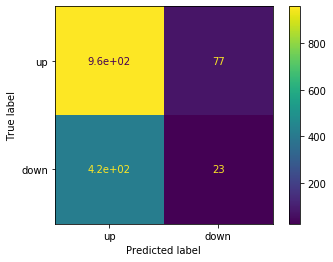

In [42]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

log_y_matrix = confusion_matrix(y_test,log_new, labels=[1,0])
ConfusionMatrixDisplay(log_y_matrix,display_labels = ['up','down']).plot();

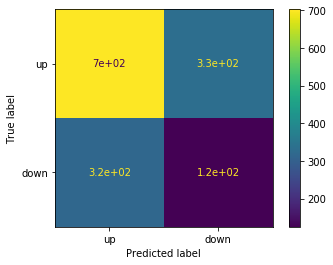

In [43]:
tree_y_matrix = confusion_matrix(y_test,tree_new, labels=[1,0])
ConfusionMatrixDisplay(tree_y_matrix, display_labels = ['up','down']).plot();

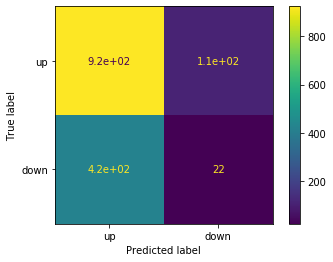

In [44]:
svm_y_matrix = confusion_matrix(y_test, svm_new,labels=[1,0])
ConfusionMatrixDisplay(svm_y_matrix, display_labels = ['up','down']).plot(); 

### Precision = 'Predicted' Total Positive

The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

Out of all the positive classes we have predicted correctly, how many are actually positive.

In [45]:
from sklearn.metrics import precision_score
log_precision = precision_score(log_new, y_test).round(3)
print('log precision score: ', log_precision)

log precision score:  0.926


In [46]:
tree_precision = precision_score(tree_new, y_test).round(3)
print('tree precision score: ', tree_precision)

tree precision score:  0.678


In [47]:
svm_precision = precision_score(svm_new, y_test).round(3)
print('svm precision score: ', svm_precision)

svm precision score:  0.892


### Recall = 'Actual' Total Positive

The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

Out of all the positive classes, we have predicted x correctly. It should be as high as possible.

In [48]:
from sklearn.metrics import recall_score
log_recall = recall_score(log_new, y_test).round(3)
print('log recall score: ', log_recall)

log recall score:  0.696


In [49]:
tree_recall = recall_score(tree_new, y_test).round(3)
print('tree recall score: ', tree_recall)

tree recall score:  0.689


In [50]:
svm_recall = recall_score(svm_new, y_test).round(3)
print('svm recall score: ', svm_recall)

svm recall score:  0.687


### F1 

It is difficult to compare two models with low precision and high recall or vice versa. So, to make them comparable, we use F-Score. F-Score helps to measure Recall and Precision at the same time. 

The F1 score can be interpreted as a weighted mean of the precision and recall, where an F1 score reaches its best value at 1 and the worst score at 0. The relative contribution of precision and recall to the F1 score are equal. The formula for the F1 score is:

F1 = 2 * (precision * recall) / (precision + recall)

In [51]:
from sklearn.metrics import f1_score
log_f1 = f1_score(log_new, y_test).round(3)
print('log f1 score: ', log_f1)

log f1 score:  0.794


In [52]:
tree_f1 = f1_score(tree_new, y_test).round(3)
print('tree f1 score: ', tree_f1)

tree f1 score:  0.683


In [53]:
svm_f1 = f1_score(svm_new, y_test).round(3)
print('svm f1 score: ', svm_f1)

svm f1 score:  0.776


## Looking Forward

In [54]:
fx_train = df[['atr', 'bbplus', 'bbminus','smaNdummy', 'adx', 'macdspread', 'rsi','stochspread']][:z]
fy_train = df[['priceiny']][:z]

fx_test = df[['atr', 'bbplus', 'bbminus','smaNdummy', 'adx', 'macdspread', 'rsi','stochspread']][z:]
fy_test = df[['priceiny']][z:]

fstd_x_train = scaler.fit(fx_train).transform(fx_train)
fstd_x_test = scaler.fit(fx_test).transform(fx_test)

log_model.fit(fstd_x_train,fy_train)
flog_train = log_model.score(fstd_x_train, fy_train).round(3)
flog_new = fstd_x_test
flog_new = log_model.predict(flog_new)

tree_model.fit(fstd_x_train,fy_train)
ftree_train = tree_model.score(fstd_x_train, fy_train).round(3)
ftree_new = fstd_x_test
ftree_new = tree_model.predict(ftree_new)

svm_model.fit(fstd_x_train,fy_train)
fsvm_train = svm_model.score(fstd_x_train, fy_train).round(3)
fsvm_new = fstd_x_test
fsvm_new = svm_model.predict(fsvm_new)

In [55]:
fx_test['log_new'] = flog_new
fx_test['tree_new'] = ftree_new
fx_test['svm_new'] = fsvm_new

In [56]:
fx_test['price'] = df['priceclose']

In [57]:
fx_test[-50:].round(2)

,atr,bbplus,bbminus,smaNdummy,adx,macdspread,rsi,stochspread,log_new,tree_new,svm_new,price
Date,,,,,,,,,,,,
2020-08-04,4.79,268.20,257.96,1,37.95,-0.20,61.42,7.94,1,1,1,271.05
2020-08-05,4.77,270.01,258.32,1,36.35,-0.33,66.91,1.92,1,1,1,274.64
2020-08-06,4.94,270.64,258.37,1,35.36,-0.37,61.91,-11.45,1,0,1,271.47
2020-08-09,4.72,271.28,258.63,1,37.59,-0.30,53.98,-13.12,1,1,1,270.31
2020-08-10,4.76,271.29,258.65,1,39.69,-0.15,50.87,-26.81,1,1,1,265.19
2020-08-11,5.05,272.19,259.73,1,40.34,0.78,57.20,7.51,1,1,1,271.86
2020-08-12,4.67,272.85,261.49,1,38.66,0.27,66.15,11.01,1,1,1,272.48
2020-08-13,4.40,273.46,262.60,1,35.66,0.51,69.37,5.42,1,1,1,272.16
2020-08-16,4.32,274.05,264.66,1,32.74,0.62,68.56,13.20,1,0,1,275.32


In [58]:
fx_test.index = pd.to_datetime(fx_test.index)

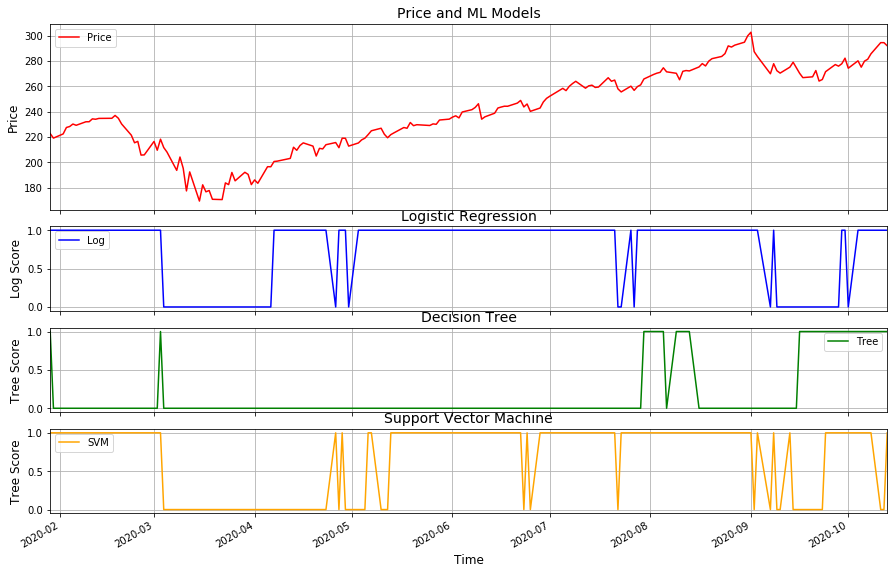

In [59]:
t= -180

import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15,10))
gridspec.GridSpec(4,1)

plt.subplot2grid((5,1), (0,0),rowspan=2)  
plt.plot(fx_test.index[t:],fx_test['price'][t:],label='Price', color='red')
plt.xlabel('Time', size=12)
plt.ylabel('Price',size=12)
plt.legend()
plt.xlim(fx_test.index[t],fx_test.index[-1])
plt.title('Price and ML Models',size=14)
plt.grid()
fig.autofmt_xdate()

plt.subplot2grid((5,1), (2,0),rowspan=1)
plt.plot(fx_test.index[t:], fx_test['log_new'][t:],label='Log', color='blue')
plt.xlabel('Time', size=12)
plt.ylabel('Log Score',size=12)
plt.xlim(fx_test.index[t],fx_test.index[-1])
plt.title('Logistic Regression',size=14)
plt.legend()
plt.grid()
fig.autofmt_xdate()

plt.subplot2grid((5,1), (3,0),rowspan=1)
plt.plot(fx_test.index[t:], fx_test['tree_new'][t:],label='Tree', color='green')
plt.xlabel('Time', size=12)
plt.ylabel('Tree Score',size=12)
plt.xlim(fx_test.index[t],fx_test.index[-1])
plt.title('Decision Tree',size=14)
plt.legend()
plt.grid()
fig.autofmt_xdate()

plt.subplot2grid((5,1), (4,0),rowspan=1)
plt.plot(fx_test.index[t:], fx_test['svm_new'][t:],label='SVM', color='orange')
plt.xlabel('Time', size=12)
plt.ylabel('Tree Score',size=12)
plt.xlim(fx_test.index[t],fx_test.index[-1])
plt.title('Support Vector Machine',size=14)
plt.legend()
plt.grid()
fig.autofmt_xdate()

plt.show()

The market should be (up=1, down=0) in N-days from now, where N-day was set at Y label at the beginning of the model. 

Good luck with the market! 

Guillaume Girard, CMT 

Fierce Research